In [1]:
# Standard IPython notebook imports
%matplotlib inline

import os

from io import StringIO
import itertools
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import scipy.stats as sstats
import scipy.optimize as sopt

import seaborn as sns
import sklearn.tree
import sklearn.ensemble

import graphviz
from numpy.linalg import inv

# Ridge Regression

When the data set is small and highly dimensional (or when high degree polynomials are used) the linear regression solution may fit the noise in the data instead of capturing the general rule. We call this phenomenon overfitting and will discuss it in detail in a few lectures.

One way of preventing overfitting is to force the model's parameters to be small. We call this *regularization*. Consider the following cost function:

$$ J(\Theta) = \frac{1}{2}\sum_{i=1}^N (y^{(i)} - \Theta^T x^{(i)})^2 + \frac{\lambda}{2} \Theta^T \Theta $$

Analyze datasets sampled using the following procedure:

1. $x \propto U(0;1)$: $x$ is sampled uniformly from the  $0-1$ range.
2. $y \propto \mathcal{N}(\mu=1+2x-5x^2 + 4x^3, \sigma=0.1)$: then 
    $y$ is sampled from the Normal distribution with mean 
    $\mu=1+2x-5x^2+4x^3$ and standard deviation $0.1$

Repeat 30 times an experiment in which you sample a new training
dataset, then fit polynomials of degree 0 to 14 and use $\lambda$
value from the set $\{0, 10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}\}$.

Plot the mean training and testing errors. What is the effect of increasing $\lambda$?

Plot how the error rates depend on the the polynomial degree and regularization constant. Try to find the best value for lambda on the test set, explain the model behavoir for small lambdas and large lambdas.

Then use a small lambda for numerical stability (1e-6) and train the model on increasingly large training sets. Plot th etraining cureves (train and test error rates versus amount of training data)

In [60]:
def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(-1,1)
    return X**powers

def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1) # len(Theta) x N
    Y = Theta.T.dot(XP)
    return Y

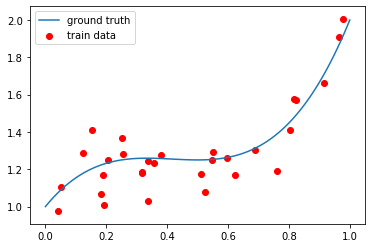

In [61]:
#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#

true_poly_theta = np.array([1, 2, -5, 4])[:, np.newaxis]

def make_dataset(N, theta=true_poly_theta, sigma=0.1):
    """ Sample a dataset """
    X = np.random.rand(N)
    Y_clean = compute_polynomial(X, theta)
    Y = Y_clean + np.random.randn(N) * sigma
    return X,Y

train_data = make_dataset(30)
XX = np.linspace(0,1,100)
YY = compute_polynomial(XX, true_poly_theta)
plt.scatter(train_data[0], train_data[1], label='train data', color='r')
plt.plot(XX, YY.ravel(), label='ground truth')
plt.legend(loc='upper left')

In [7]:
def poly_fit(data, degree, _lambda):
    "Fit a polynomial of a given degree and weight decay parameter _lambda"
    X = powers_of_X(data[0], degree) # Matrix d x N
    Y = data[1].reshape(1, -1)       # Matrix 1 x N
    #
    # implement the closed-form solution for Theta
    #
    # Please note that np.inv may be numerically unstable.
    # It is better to use np.linalg.solve or even a QR decomposition.
    #
    # (X.T x X + _lambda x I)^-1 x X.T x Y
    I = np.eye(degree + 1)
    q, r = np.linalg.qr(np.dot(X, X.T) + _lambda * I, mode='complete')
    _inv = np.dot(inv(r), q.T)
    Theta = np.dot(np.dot(_inv, X), Y.T)
    return Theta

In [9]:
def error(Theta, X, Y, _lambda):
    vals = compute_polynomial(X, Theta)
    return np.mean((vals - Y) ** 2, axis=0)

In [10]:
num_test_samples = 100
num_train_samples = [30]
lambdas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
degrees = range(15)
num_repetitions = 30


#sample a single test dataset for all experiments
test_data = make_dataset(num_test_samples)
results = []

for (repetition,
     num_train,
     _lambda,
     degree,) in itertools.product(
         range(num_repetitions),
         num_train_samples,
         lambdas,
         degrees):
    train_data = make_dataset(num_train)
    Theta = poly_fit(train_data, degree, _lambda)

    train_err = cost_ridge(Theta, train_data[0], train_data[1], _lambda)
    test_err = cost_ridge(Theta, test_data[0], test_data[1], _lambda)
    
    results.append({'repetition': repetition,
                    'num_train': num_train,
                    'lambda': _lambda,
                    'degree': degree,
                    'dataset': 'train',
                    'err_rate': train_err})
    results.append({'repetition': repetition,
                    'num_train': num_train,
                    'lambda': _lambda,
                    'degree': degree,
                    'dataset': 'test',
                    'err_rate': test_err})
results_df = pd.DataFrame(results)
results_df.sample(5)

,dataset,degree,err_rate,lambda,num_train,repetition
1203,test,1,0.023006,0.000000,30,5
2226,train,3,0.009323,0.000010,30,9
2202,train,6,0.007005,0.000001,30,9
3522,train,6,0.010679,0.010000,30,14
5085,test,7,0.013526,0.000001,30,21


In [11]:
train = results_df[results_df['dataset'] == 'train']
test = results_df[results_df['dataset'] == 'test']

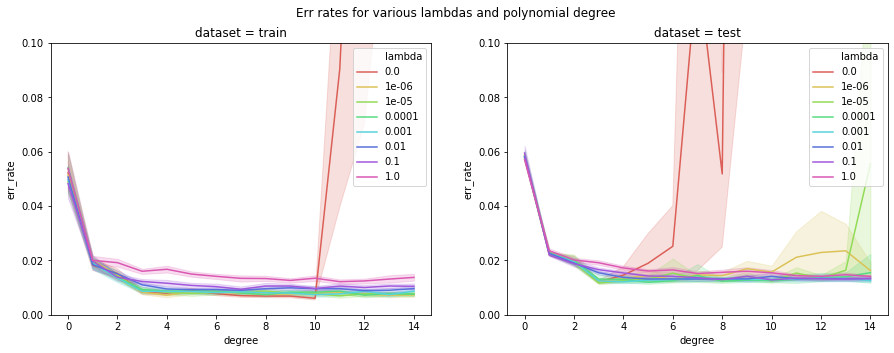

Wall time: 2.84 s


In [12]:
%%time
#
# Plot how the error rates depend on the the polynomial degree and regularization
# constant.
# Try to find the best value for lambda on the test set, explain the model
# behavoir for small lambdas and large lambdas.
#
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_ylim([0, 0.1])
ax[1].set_ylim([0, 0.1])
ax[0].set_title('dataset = train')
ax[1].set_title('dataset = test')

sns.lineplot(x=train['degree'], y=train['err_rate'], 
             hue=train['lambda'], 
             palette=sns.color_palette("hls", len(lambdas)),
             ax=ax[0])

sns.lineplot(x=test['degree'], y=test['err_rate'], 
             hue=test['lambda'], 
             palette=sns.color_palette("hls", len(lambdas)),
             ax=ax[1])

plt.suptitle('Err rates for various lambdas and polynomial degree')
plt.show()

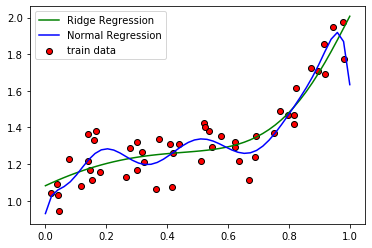

In [110]:
# fit ridge regression
N = 50
train_data = make_dataset(N)
degree = 10
_lambda = 0.01
x_space = np.linspace(0, 1, N)
Theta_ridge = poly_fit(train_data, degree, _lambda)

X = powers_of_X(train_data[0], degree) # Matrix d x N
Y = train_data[1].reshape(1, -1)       # Matrix 1 x N
Theta_regression = inv(X.dot(X.T)).dot(X).dot(Y.T)

Y_ridge = compute_polynomial(x_space, Theta_ridge)
Y_regression = compute_polynomial(x_space, Theta_regression)

plt.scatter(train_data[0], train_data[1], label='train data', 
            color='r', edgecolors='black')
plt.plot(x_space, Y_ridge.ravel(), label='Ridge Regression', c='green')
plt.plot(x_space, Y_regression.ravel(), label='Normal Regression', c='blue')
plt.legend(loc='upper left')